# import packages

In [84]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as scipy

# Comment this if the data visualisations doesn't work on your side
%matplotlib inline

import numpy as np
from sklearn.ensemble import GradientBoostingRegressor  #GBM algorithm
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
from sklearn.metrics import mean_squared_error

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
import timeit

# read file

In [72]:
train = pd.read_csv('train.csv')
train = train.drop(['Unnamed: 0'], axis=1)
train.head(5)

#train.dtypes
#train.shape
#sum(np.isnan(train['review_scores_rating']))

,id,host_is_superhost,property_type_Apartment,property_type_Guest suite,property_type_House,property_type_Loft,property_type_Townhouse,property_type_Bed and breakfast,property_type_Condominium,property_type_Boutique hotel,...,neighbourhood_cleansed_Westchester Square,neighbourhood_cleansed_Westerleigh,neighbourhood_cleansed_Whitestone,neighbourhood_cleansed_Williamsbridge,neighbourhood_cleansed_Williamsburg,neighbourhood_cleansed_Windsor Terrace,neighbourhood_cleansed_Woodhaven,neighbourhood_cleansed_Woodlawn,neighbourhood_cleansed_Woodrow,neighbourhood_cleansed_Woodside
0,6374694,0,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7218561,1,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,20553159,0,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,17415890,0,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,16825557,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [73]:
target = 'review_scores_rating'
ID = 'id'

In [74]:
test = pd.read_csv('test.csv')
test.head(5)
test.shape

(9581, 435)

# Define a function 
which will help us create GBM models and perform cross-validation.

In [77]:
def modelfit(alg, dtrain, predictors, performCV=True, printFeatureImportance=True):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['review_scores_rating'])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    #dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #Perform cross-validation:
    #if performCV:
        #cv_score = cross_validation.cross_val_score(alg, dtrain[predictors], dtrain['review_scores_rating'], cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print ("\nModel Report")
    #print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain['review_scores_rating'].values, dtrain_predictions))
    #print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['review_scores_rating'], dtrain_predprob))
    
    #if performCV:
        #print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

# baseline model

In [95]:
#lossfunction = scipy.special.huber

In [75]:
#Choose all predictors except target & IDcols
predictors = [x for x in train.columns if x not in [target, ID]]
gbm0 = GradientBoostingRegressor(random_state=10)
#train_temp = train[0:100]
fit= gbm0.fit(train[predictors], train[target])

In [76]:
type(fit.feature_importances_[0:10])

numpy.ndarray

In [78]:
train_predictions = fit.predict(train[predictors])
MSE_train = np.sqrt(mean_squared_error(train[target], train_predictions))
print('MSE of the GBM on test set: {:.5f}'.format(MSE_train))

MSE of the GBM on test set: 7.18668


In [79]:
test_predictions = fit.predict(test[predictors])
MSE_test = np.sqrt(mean_squared_error(test[target], test_predictions))
print('MSE of the GBM on test set: {:.5f}'.format(MSE_test))

MSE of the GBM on test set: 9.57046


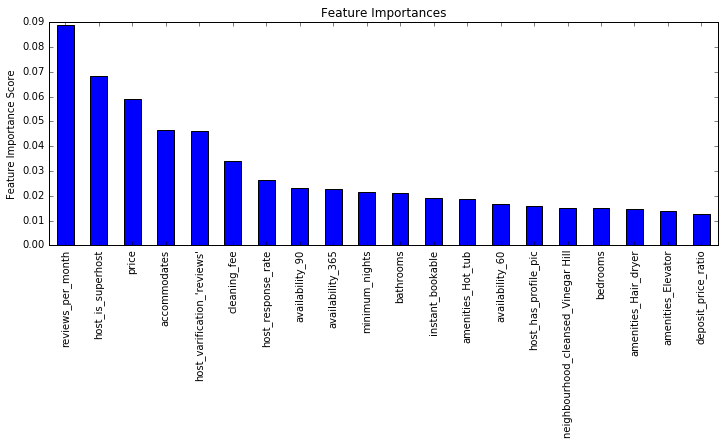

In [17]:

feat_imp = pd.Series(fit.feature_importances_, predictors).sort_values(ascending=False)
feat_imp[:20].plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

## Learning rate and number of parameters
Learning rate: [0.05, 0.10,0.12,0.14,0.16,0.18]
number of estimators: from 80 to 150, step 10

In [45]:
#train_temp = train[0:100]
#if the values are too high ~100, tuning the other parameters will take long time and you can try a higher learning rate
predictors = [x for x in train.columns if x not in [target, ID]]
param_test1 = {'n_estimators': list(range(100,181,10))}
gsearch1 = GridSearchCV(estimator = 
                        GradientBoostingRegressor(learning_rate = 0.15, min_samples_split=500,min_samples_leaf=50,
                                                  max_depth=8,max_features='sqrt',subsample=0.8,random_state=10), 
                        param_grid = param_test1, n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.15, loss='ls', max_depth=8,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=50, min_samples_split=500,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=10, subsample=0.8, verbose=0,
             warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'n_estimators': [100, 110, 120, 130, 140, 150, 160, 170, 180]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [46]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.11825, std: 0.01310, params: {'n_estimators': 100},
  mean: 0.11903, std: 0.01335, params: {'n_estimators': 110},
  mean: 0.11960, std: 0.01315, params: {'n_estimators': 120},
  mean: 0.12003, std: 0.01366, params: {'n_estimators': 130},
  mean: 0.12012, std: 0.01483, params: {'n_estimators': 140},
  mean: 0.11987, std: 0.01581, params: {'n_estimators': 150},
  mean: 0.12068, std: 0.01668, params: {'n_estimators': 160},
  mean: 0.12044, std: 0.01789, params: {'n_estimators': 170},
  mean: 0.11957, std: 0.01886, params: {'n_estimators': 180}],
 {'n_estimators': 160},
 0.12068398155495641)

## max depth and min samples split
Test max_depth values of 5 to 15 in steps of 2 and min_samples_split from 200 to 1000 in steps of 200

In [55]:
param_test2 = {'max_depth':list(range(5,16,2)), 'min_samples_split':list(range(900,1201,50))}
gsearch2 = GridSearchCV(estimator = 
                        GradientBoostingRegressor(learning_rate=0.15, n_estimators=160,
                                                  max_features='sqrt', subsample=0.8, random_state=10), 
                        param_grid = param_test2, n_jobs=4,iid=False, cv=5)
gsearch2.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.15, loss='ls', max_depth=3,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=160,
             presort='auto', random_state=10, subsample=0.8, verbose=0,
             warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'max_depth': [5, 7, 9, 11, 13, 15], 'min_samples_split': [900, 950, 1000, 1050, 1100, 1150, 1200]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [56]:
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.11481, std: 0.01783, params: {'max_depth': 5, 'min_samples_split': 900},
  mean: 0.11434, std: 0.01994, params: {'max_depth': 5, 'min_samples_split': 950},
  mean: 0.11691, std: 0.01443, params: {'max_depth': 5, 'min_samples_split': 1000},
  mean: 0.11427, std: 0.01994, params: {'max_depth': 5, 'min_samples_split': 1050},
  mean: 0.11479, std: 0.01828, params: {'max_depth': 5, 'min_samples_split': 1100},
  mean: 0.11849, std: 0.01669, params: {'max_depth': 5, 'min_samples_split': 1150},
  mean: 0.11287, std: 0.01848, params: {'max_depth': 5, 'min_samples_split': 1200},
  mean: 0.11734, std: 0.01983, params: {'max_depth': 7, 'min_samples_split': 900},
  mean: 0.11868, std: 0.02087, params: {'max_depth': 7, 'min_samples_split': 950},
  mean: 0.11861, std: 0.01814, params: {'max_depth': 7, 'min_samples_split': 1000},
  mean: 0.11996, std: 0.01909, params: {'max_depth': 7, 'min_samples_split': 1050},
  mean: 0.11953, std: 0.01781, params: {'max_depth': 7, 'min_samples_split': 110

## Min_sample_spilt and min_sample_leaf


In [65]:
param_test3 = {'min_samples_split':list(range(900,1201,50)), 'min_samples_leaf': list(range(30,81,5))}
gsearch3 = GridSearchCV(estimator = 
                        GradientBoostingRegressor(learning_rate=0.15, n_estimators=160, max_depth = 9,
                                                  max_features='sqrt', subsample=0.8, random_state=10), 
                        param_grid = param_test3, n_jobs=4,iid=False, cv=5)
gsearch3.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.15, loss='ls', max_depth=9,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=160,
             presort='auto', random_state=10, subsample=0.8, verbose=0,
             warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'min_samples_split': [900, 950, 1000, 1050, 1100, 1150, 1200], 'min_samples_leaf': [30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [66]:
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.12172, std: 0.02010, params: {'min_samples_leaf': 30, 'min_samples_split': 900},
  mean: 0.11791, std: 0.01867, params: {'min_samples_leaf': 30, 'min_samples_split': 950},
  mean: 0.12140, std: 0.01698, params: {'min_samples_leaf': 30, 'min_samples_split': 1000},
  mean: 0.12309, std: 0.01611, params: {'min_samples_leaf': 30, 'min_samples_split': 1050},
  mean: 0.12032, std: 0.01705, params: {'min_samples_leaf': 30, 'min_samples_split': 1100},
  mean: 0.12461, std: 0.01873, params: {'min_samples_leaf': 30, 'min_samples_split': 1150},
  mean: 0.12086, std: 0.01573, params: {'min_samples_leaf': 30, 'min_samples_split': 1200},
  mean: 0.12011, std: 0.01667, params: {'min_samples_leaf': 35, 'min_samples_split': 900},
  mean: 0.11906, std: 0.01768, params: {'min_samples_leaf': 35, 'min_samples_split': 950},
  mean: 0.11809, std: 0.02042, params: {'min_samples_leaf': 35, 'min_samples_split': 1000},
  mean: 0.12234, std: 0.01551, params: {'min_samples_leaf': 35, 'min_samples_split':

## max features
The square root of features is usually a good starting point.  square root of 400~
Trying values from 10 to 29 in steps of 2

In [21]:
param_test4 = {'max_features':list(range(20,40,2))}
gsearch4 = GridSearchCV(estimator = 
                        GradientBoostingRegressor(learning_rate=0.15, n_estimators=160,max_depth=9, 
                                                  min_samples_split=1150, min_samples_leaf=30, subsample=0.8, random_state=10),
                        param_grid = param_test4, n_jobs=4,iid=False, cv=5)
gsearch4.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.15, loss='ls', max_depth=9, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=30,
             min_samples_split=1150, min_weight_fraction_leaf=0.0,
             n_estimators=160, presort='auto', random_state=10,
             subsample=0.8, verbose=0, warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'max_features': [20, 22, 24, 26, 28, 30, 32, 34, 36, 38]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [22]:
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.12461, std: 0.01873, params: {'max_features': 20},
  mean: 0.11996, std: 0.01463, params: {'max_features': 22},
  mean: 0.11958, std: 0.01800, params: {'max_features': 24},
  mean: 0.12532, std: 0.02477, params: {'max_features': 26},
  mean: 0.12244, std: 0.02437, params: {'max_features': 28},
  mean: 0.12120, std: 0.02200, params: {'max_features': 30},
  mean: 0.12420, std: 0.02340, params: {'max_features': 32},
  mean: 0.12485, std: 0.02437, params: {'max_features': 34},
  mean: 0.12269, std: 0.02314, params: {'max_features': 36},
  mean: 0.12226, std: 0.02276, params: {'max_features': 38}],
 {'max_features': 26},
 0.12531554141685466)

## subsample

In [23]:
param_test5 = {'subsample':[0.6,0.7,0.8,0.85,0.9]}
gsearch5 = GridSearchCV(estimator = 
                        GradientBoostingRegressor(learning_rate=0.1, n_estimators=160,max_depth=13, 
                                                  min_samples_split=1200, min_samples_leaf=10, max_features = 34, random_state=10),
                        param_grid = param_test5, n_jobs=4,iid=False, cv=5)
gsearch5.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=13, max_features=34,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=10,
             min_samples_split=1200, min_weight_fraction_leaf=0.0,
             n_estimators=160, presort='auto', random_state=10,
             subsample=1.0, verbose=0, warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'subsample': [0.6, 0.7, 0.8, 0.85, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [24]:
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: 0.12638, std: 0.02274, params: {'subsample': 0.6},
  mean: 0.13275, std: 0.02291, params: {'subsample': 0.7},
  mean: 0.13396, std: 0.02734, params: {'subsample': 0.8},
  mean: 0.13656, std: 0.02697, params: {'subsample': 0.85},
  mean: 0.13300, std: 0.02656, params: {'subsample': 0.9}],
 {'subsample': 0.85},
 0.13655598159780774)

## Evaluation of new model on test set

In [88]:
start = timeit.default_timer()
predictors = [x for x in train.columns if x not in [target, ID]]
gbm_new = GradientBoostingRegressor(learning_rate=0.15, max_depth=9,n_estimators=160, min_samples_split=1150, 
                                    min_samples_leaf=30, max_features = 34, subsample =0.85, random_state=10)
fit_new= gbm_new.fit(train[predictors], train[target])
stop = timeit.default_timer()
print('Time: ', stop - start)

Time:  25.322267860989086


In [82]:
train_predictions = fit_new.predict(train[predictors])
MSE_train = np.sqrt(mean_squared_error(train[target], train_predictions))
print('MSE of the GBM on test set: {:.5f}'.format(MSE_train))

MSE of the GBM on test set: 6.93137


In [83]:
test_predictions = fit_new.predict(test[predictors])
MSE_test = np.sqrt(mean_squared_error(test[target], test_predictions))
print('MSE of the GBM on test set: {:.5f}'.format(MSE_test))

MSE of the GBM on test set: 9.54843


Text(0,0.5,'Feature Importance Score')

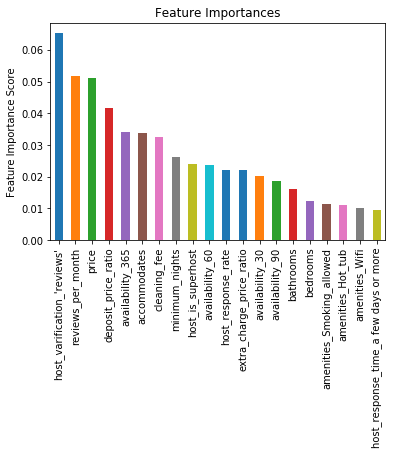

In [37]:
feat_imp = pd.Series(fit_new.feature_importances_, predictors).sort_values(ascending=False)
feat_imp[:20].plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')